In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
# Zonals stats packages
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep


et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

In [2]:
# Demo pandas subsetting, renaming




In [3]:
# Breaking down code to understand what it does

In [4]:
# Review -- chm -- what is it

## Import Canopy Height Model
 

In [5]:
sjer_data_path = os.path.join("data", "spatial-vector-lidar", "california", 
                             "neon-sjer-site")
sjer_chm_path = os.path.join(sjer_data_path, "2013", "lidar", "SJER_lidarCHM.tif")

with rio.open(sjer_chm_path) as sjer_lidar_chm_src:
    sjer_lidar_chm=sjer_lidar_chm_src.read(1, masked=True)
    # Create metadata object to view later
    sjer_lidar_chm_meta=sjer_lidar_chm_src.profile
    sjer_plot_extent=plotting_extent(sjer_lidar_chm_src)

sjer_lidar_chm.shape
# view metadata
sjer_lidar_chm_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4296, 'height': 5059, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(1.0, 0.0, 254571.0,
       0.0, -1.0, 4112362.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

## Plot a histogram

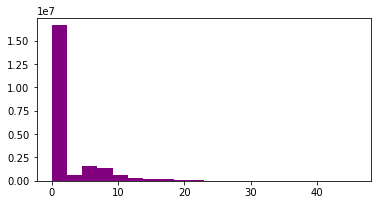

In [6]:
ep.hist(sjer_lidar_chm,
       figsize=(6,3))
plt.show()

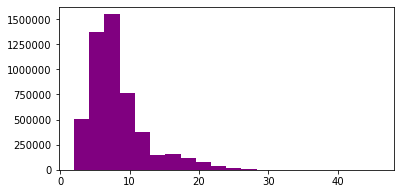

In [7]:
# Set all values ==0 to na (no data) 
# as 0s will bring down our summary mean values
sjer_lidar_chm[sjer_lidar_chm == 0] = np.nan

# Remove na values from the array
# Only perform this step for the histogram! 
# Not needed for your data processing
sjer_lidar_chm_no_na = sjer_lidar_chm[~np.isnan(sjer_lidar_chm)]

ep.hist(sjer_lidar_chm_no_na,
       figsize=(6,3))
plt.show()

## Import The Plot Location Data

In [8]:
# Open up your plot locations - shapefile
sjer_centroids_path = os.path.join(sjer_data_path, "vector_data", "SJER_plot_centroids.shp")

sjer_plot_points = gpd.read_file(sjer_centroids_path)
# Notice that the geometry is in POINT format now
sjer_plot_points.head(3)

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,POINT (255852.376 4111567.818)
1,SJER112,center,4111298.971,257406.967,trees,POINT (257406.967 4111298.971)
2,SJER116,center,4110819.876,256838.760,grass,POINT (256838.760 4110819.876)


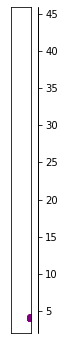

In [9]:
# The plot below looks funky -- look closely at the plot code
# Here, you can see that the extent is not provided for the raster data
fig, ax = plt.subplots(figsize=(6, 6))
ep.plot_bands(sjer_lidar_chm, cmap="Greys",
              #extent=sjer_plot_extent,
              ax=ax, scale=False)

# Plot a geopandas VECTOR layer which is a (shapefile in this case)
sjer_plot_points.plot(ax=ax,
                      color="purple")

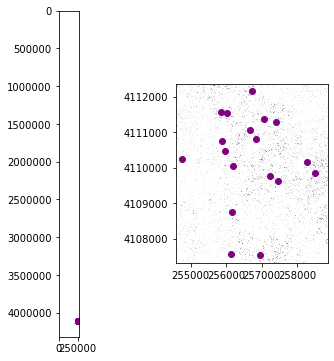

In [10]:
# This is just a demo. here i just plotting using
# "vanilla" matplotlib and the x and y ticks are visible. notice the extreme 
# range of values. your data are there - they just are plotted in the correct spatial location
# specifically the raster data are not

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6))

ax1.imshow(sjer_lidar_chm, cmap="Greys")
sjer_plot_points.plot(ax=ax1,
                      color="purple")
# This plot has a plotting extent set - notice how things line up
ax2.imshow(sjer_lidar_chm, cmap="Greys",
         extent=sjer_plot_extent,)
sjer_plot_points.plot(ax=ax2,
                      color="purple")
# Remember to not use plt.show() in your homework but for other purposes it is great to hide the 
# matplotlib text output!
plt.show()

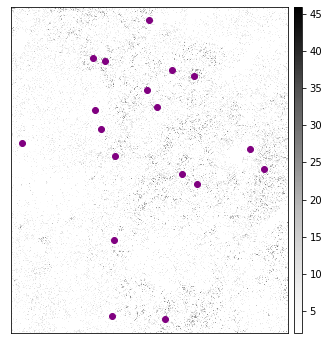

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
ep.plot_bands(sjer_lidar_chm, cmap="Greys",
              extent=sjer_plot_extent,
              ax=ax, scale=False)

# Plot a geopandas VECTOR layer (shapefile in this case)
sjer_plot_points.plot(ax=ax,
                      color="purple")
plt.show()

# Buffer the points to make a polygon 

In [12]:
# Buffer the points
sjer_plots_poly = sjer_plot_points.copy()
sjer_plots_poly["geometry"] = sjer_plot_points.geometry.buffer(20)
# View the top few lines - notice that the geometry is now in polygon rather than point format!
sjer_plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.280 4..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.871 4..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.760 4110819.876, 256858.664 4..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.851 4..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.276 4..."


In [13]:
# Export newly created buffer data as a shapefile
plot_buffer_path = os.path.join("data", "spatial-vector-lidar", "outputs", "sjer_plot_buffer.shp")
sjer_plots_poly.to_file(plot_buffer_path)

## Zonal Stats To Create Spatial Data 

In the example below, you run zonal stats. There are many parameters below that you do'nt need if all you want to do is output the data (and you don't need the spatial elements. I have added additional steps below to show you how to ruun zonal stats and turn it into a spatial object that you can plot. 

run help(rs.zonal_stats) --to see what all of those parameters do below!
`help(rs.gen_zonal_stats)` <- this is actually the function with the full docstring that you'll want to look at.

In [14]:
# Run zonal stats 
sjer_lidar_tree_heights = rs.zonal_stats(plot_buffer_path,
                                        sjer_lidar_chm,
                                        affine=sjer_lidar_chm_meta["transform"], # this provides CRS information
                                        geojson_out=True,
                                        copy_properties=True,
                                        nodata=0, 
                                        stats=["mean", "max"])
type(sjer_lidar_tree_heights)
# conver the list output to a geodataframe

list

In [15]:
# While you don't need a GDF to do this analysis this will allow you to plot the data later by tree height!!
sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_lidar_tree_heights)
sjer_lidar_height_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,max,mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544348
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675347
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591176


In [16]:
# Optional but recommended - rename columns to be clear about what metrics they contain
# note that inplace specifies that you want pandas to modify the original dataframe (in place) rather than creating a new object
sjer_lidar_height_df.rename(columns={"max":"lidar_max",
                                    "mean": "lidar_mean"}, inplace=True)

# Look at the new column names. they are more expressive than they were before. 
# This will become important as you merge the insitu data with this data below!
sjer_lidar_height_df.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544348
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675347
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591176


## Compare Human Measured Tree Heights
Next you will import the data that has human measured tree heights. 
you will use this data to compare to the lidar data information that you calculated above!

conceptually the steps are similar but in this case you already have the data in a dataframe so you just need to calculate sumary statistics. 

In [17]:
# Import the csv of human measured (insitu) tree height data
path_insitu = os.path.join(sjer_data_path, "2013", "insitu", "veg_structure","D17_2013_SJER_vegStr.csv")
sjer_insitu_all = pd.read_csv(path_insitu)
sjer_insitu_all.columns

# Keep only the needed columns - this is one way to subset a pandas dataframe by column name
sjer_insitu = sjer_insitu_all[["siteid","sitename","plotid","stemheight"]]
sjer_insitu.head()

,siteid,sitename,plotid,stemheight
0,SJER,San Joaquin,SJER128,18.2
1,SJER,San Joaquin,SJER2796,3.3
2,SJER,San Joaquin,SJER272,1.7
3,SJER,San Joaquin,SJER112,2.1
4,SJER,San Joaquin,SJER272,3.0


Below you are calculating the mean and max height value for each plot. you are using the `stemheight` column to calculate these values. 

In [18]:
# Get mean and max tree height for each plot
insitu_stem_ht = sjer_insitu.groupby("plotid").agg(["mean","max"])["stemheight"]
insitu_stem_ht = insitu_stem_ht.reset_index()
insitu_stem_ht.head()

,plotid,mean,max
0,SJER1068,3.866667,19.3
1,SJER112,8.221429,23.9
2,SJER116,8.218750,16.0
3,SJER117,6.512500,11.0
4,SJER120,7.600000,8.8


## Rename Columns
Renaming columns can be useful to keep your data tidy and to keep track of what columns contains what metrics.

In [19]:
# It could be a good idea to rename columns so the data are clear
insitu_stem_ht.rename(columns={"mean": "insitu_mean",
                      "max": "insitu_max"}, inplace=True)
insitu_stem_ht.columns

Index(['plotid', 'insitu_mean', 'insitu_max'], dtype='object')

Once you are done, you can then MERGE the human measured tree height data sumnmarized above with the lidar summaries that you created. this creates ONE dataframe with all of the data you need to run your comparisons. 

In [20]:
# Merge the lidar df with the insitu by the plot id
sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                          left_on="Plot_ID",
                          right_on="plotid")

In [21]:
sjer_final_height.head()

,geometry,Plot_ID,Point,northing,easting,plot_type,lidar_max,lidar_mean,plotid,insitu_mean,insitu_max
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,4111567.818,255852.376,trees,19.049999,11.544348,SJER1068,3.866667,19.3
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,4111298.971,257406.967,trees,24.019999,10.369277,SJER112,8.221429,23.9
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,4110819.876,256838.760,grass,16.070000,7.518398,SJER116,8.218750,16.0
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,4108752.026,256176.947,trees,11.059999,7.675347,SJER117,6.512500,11.0
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,4110476.079,255968.372,grass,5.740000,4.591176,SJER120,7.600000,8.8


In [22]:
# Now you can plot your data using matplotlib. !

## Bonus! A Spatial Plot

Below you can just see how you created a new dataset that can also be plotted spatially which is pretty cool!!


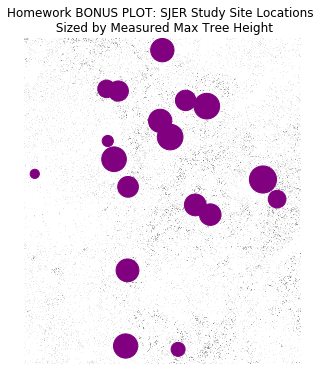

In [23]:

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(sjer_lidar_chm,
          cmap='Greys',
          extent=sjer_plot_extent)

# overlay field site locations
sjer_final_height.centroid.plot(ax=ax,
                          marker='o',
                          markersize=sjer_final_height['insitu_mean']*80, c='purple')

# add title
ax.set_title(
    "Homework BONUS PLOT: SJER Study Site Locations \n Sized by Measured Max Tree Height")
ax.set_axis_off()
plt.show()